## 라이프러리 임포트 및 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [5]:
df = pd.read_csv('wowah_data.csv')
zones = pd.read_csv('zones.csv')
locations = pd.read_csv('locations.csv')

## 데이터 컬럼 및 날짜 변수 전처리

In [6]:
# 컬럼명에 있는 공백 제거
for col in df.columns:
    df = df.rename(columns={col:col.strip()})

In [7]:
# timestamp 컬럼 datetime 유형으로 변경
df['time'] = pd.to_datetime(df['timestamp'])

In [8]:
df = df.rename(columns={'time':'datetime'})

In [9]:
df['year'] = df['datetime'].dt.year  
df['month'] = df['datetime'].dt.month  

In [10]:
df['date'] = df['datetime'].dt.date  
df['time'] = df['datetime'].dt.time  

### 이탈 유저 데이터 추출
    
 * 유저별 첫번째 및 마지막 활동 로그를 추출
 * 90일 이상 접속하지 않은 유저를 이탈한 유저로 규정하고 이탈 사용자 데이터셋을 추출

In [11]:
df = df.sort_values(by=['char', 'datetime']).reset_index()

In [12]:
# 유저별 첫번째 및 마지막 활동 로그 추출
first_log = df.groupby('char').first()
last_log = df.groupby('char').last()

In [13]:
first_log = first_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()
last_log = last_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()

In [14]:
first_log = first_log.rename(columns={'datetime':'first_log_time'})
last_log = last_log.rename(columns={'datetime':'last_log_time'})

In [15]:
# 90일 이상 접속하지 않은 유저를 이탈한 유저로 규정
last_log['churn'] = pd.to_datetime('2008-12-31') - last_log.last_log_time > timedelta(days=90)
last_log['churn'] = last_log['churn'].astype('int')

In [16]:
churn_users = last_log[last_log.churn==1].reset_index()

In [17]:
#이탈률 평균값
last_log.churn.mean() * 100

45.07683246774107

### 유저의 평균 게임 구독 기간
* 구독 중단 시점을 정확히 알긴 어려우나, 첫번째 및 마지막 로그 기록을 통해 대략적인 범위를 유추
* 이탈 여부에 따라 구독 기간이 어떻게 다른지 집계함.

In [18]:
#유저별 첫 접속 및 마지막 접속시간
user_time = pd.merge(first_log, last_log[['char', 'last_log_time']], on='char')

In [19]:
user_time['subscription'] = user_time['last_log_time'] - user_time['first_log_time']

In [20]:
user_time.subscription.mean() #보통 유저들은 72일 정도 계정을 유지

Timedelta('72 days 14:25:04.162472562')

In [21]:
user_time['subscription(days)'] = [dt.days for dt in user_time['subscription'] ]

In [39]:
churn_ids = list(churn_users.char)
user_time['churn'] = [ '이탈함' if x in churn_ids else '이탈하지 않음' for x in user_time.char]

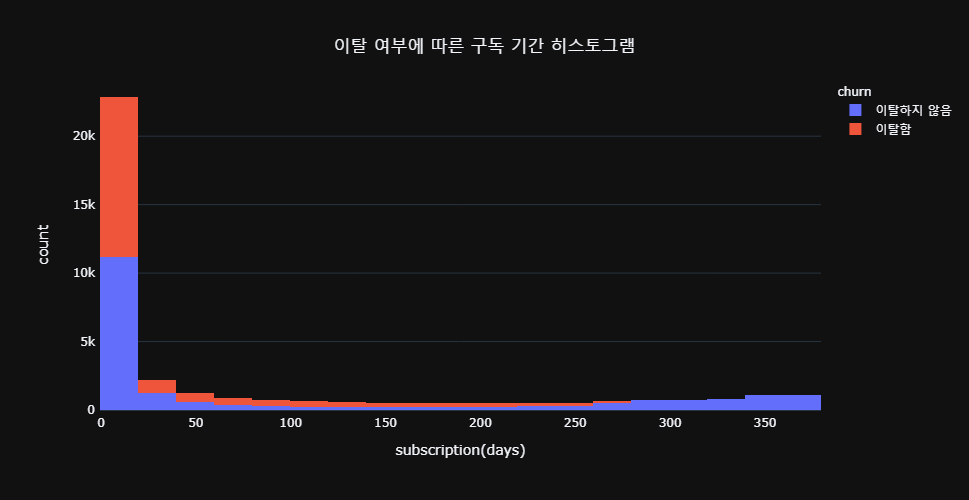

In [40]:
fig = px.histogram(user_time, x="subscription(days)", nbins=20, template='plotly_dark', text_auto=True, color='churn')

fig.update_layout(width=800, height=500,
                  title={
                    'text': "이탈 여부에 따른 구독 기간 히스토그램",
                    'y':0.92,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  template='plotly_dark',
                  margin=dict(
                        l=100,
                        r=50,
                        b=90,
                        t=80,
                        pad=4
                    )
                 )
fig.show()
fig.write_image("img/subscription_churn_users.png")

## 이탈율 분석
* 매일 dau 대비 몇 %의 유저가 이탈했는지 확인

In [206]:
churn_users['date'] = churn_users['last_log_time'].dt.date  

In [207]:
#일별 이탈 유저 수
daily_churn = churn_users.groupby('date').churn.sum().reset_index()

In [208]:
#dau
dau = pd.DataFrame(df.groupby('date').char.nunique()).reset_index()

In [209]:
daily_chrun_dau = pd.merge(dau, daily_churn, on='date', how='left')
daily_chrun_dau['churn_rate'] = daily_chrun_dau.churn / daily_chrun_dau.char

daily_chrun_dau = daily_chrun_dau[~daily_chrun_dau.churn_rate.isna()]

In [212]:
del daily_chrun_dau['char']

In [213]:
#이탈율 기술통계값 확인
daily_chrun_dau['churn_rate'].describe()

count    261.000000
mean       0.031959
std        0.009071
min        0.015262
25%        0.025926
50%        0.030405
75%        0.037237
max        0.076804
Name: churn_rate, dtype: float64

In [214]:
daily_chrun_dau['churn_rate_re'] = [round(x, 3) for x in daily_chrun_dau['churn_rate']]

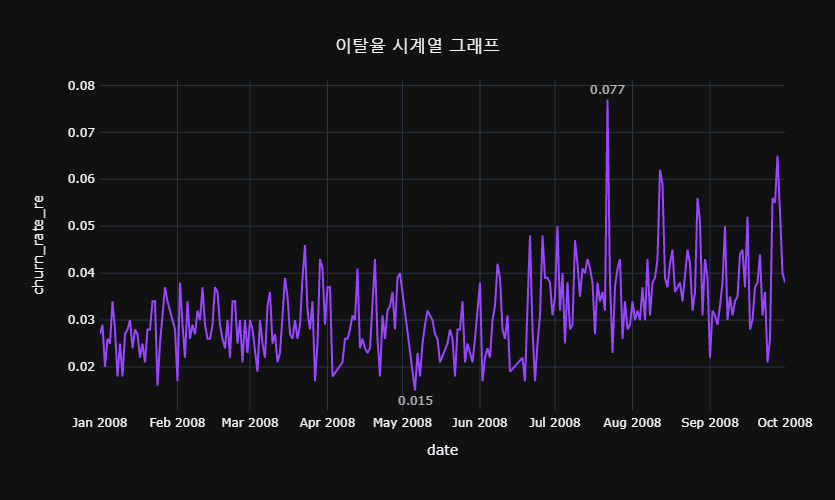

<Figure size 720x288 with 0 Axes>

In [246]:
plt.figure(figsize = (10,4))


fig = px.line(daily_chrun_dau, x="date", y="churn_rate_re", template='plotly_dark', color_discrete_sequence=['#9747ff'])
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=daily_chrun_dau.date[daily_chrun_dau.max(axis = 1).idxmax()],
                   y=daily_chrun_dau.max().churn_rate_re,
                   text=str(daily_chrun_dau.max().churn_rate_re),
                   yshift=10,
                   opacity=0.7)
fig.add_annotation(showarrow=False,
                   align = 'right',
                   x=daily_chrun_dau.date[daily_chrun_dau.min(axis = 1).idxmin()],
                   y=daily_chrun_dau.min().churn_rate_re,
                   text=str(daily_chrun_dau.min().churn_rate_re),
                   yshift=-10,
                   opacity=0.7)


fig.update_layout(width=1200, height=500,
                  title={
                    'text': "이탈율 시계열 그래프",
                    'y':0.92,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  template='plotly_dark',
                  margin=dict(
                        l=100,
                        r=50,
                        b=90,
                        t=80,
                        pad=4
                    )
                 )

fig.show()
fig.write_image("img/churn_rate.png")

* 이탈율은 평균 3.2% 수준이며, 2008년 6월까지는 항상 5% 미만을 기록함.    
    
* 그러나 이후 다소 증가하는 추세이며, 7월 22일에는 7.7%로 가장 높은 수치를 기록함. 

### 레벨별 이탈율
* 이탈한 유저들이 어느 레벨에서 많이 이탈했는지 분석함.

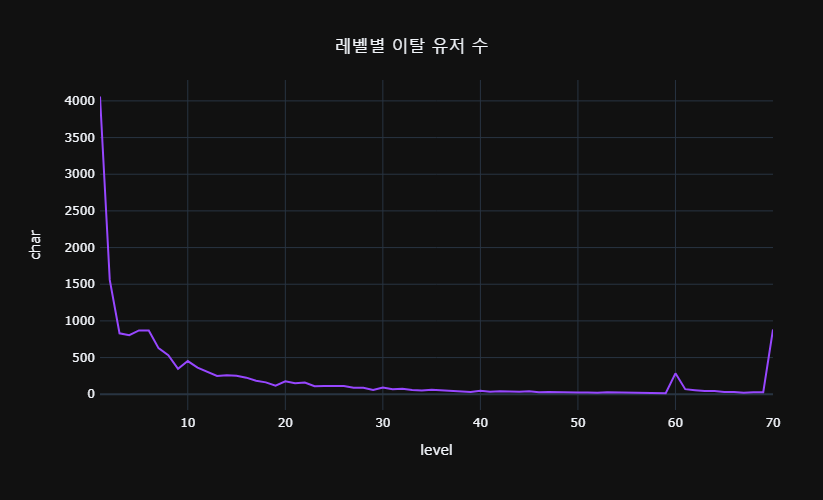

In [247]:
churn_level = churn_users.groupby('level').char.count().reset_index()

fig = px.line(churn_level, x="level", y="char", template='plotly_dark', width=800, height=500, color_discrete_sequence=['#9747ff'])

fig.update_layout(width=800, height=500,
                  title={
                    'text': "레벨별 이탈 유저 수",
                    'y':0.92,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  template='plotly_dark',
                  margin=dict(
                        l=100,
                        r=50,
                        b=90,
                        t=80,
                        pad=4
                    )
                 )

fig.show()
fig.write_image("img/churn_level.png")

* 레벨 10 이하에서 많이 떠나므로 레벨 10까지 도달하게 만드는 것이 중요    
    
* 레벨 60에서도 다소 떠난 유저가 많아 게임을 지속할 새로운 요인을 제공할 필요가 있음.
* 최고 레벨인 70 이후에 떠나는 유저들은 더이상 할 것이 없어서 떠나는 것으로 보임.

### 지역별 이탈율
* 지역별로 해당 지역에서의 활동을 마지막으로 이탈한 유저의 비율을 계산함.

In [36]:
churn_zone = last_log.groupby('zone').agg({'char':'count', 'churn':'sum'}).reset_index()
churn_zone['churn_rate'] = churn_zone['churn'] / churn_zone['char']
churn_zone_top10 = churn_zone.sort_values(by='churn_rate', ascending=False)
churn_zone_top10 = churn_zone_top10[:10].sort_values(by='churn_rate', ascending=True)

In [37]:
churn_zone_top10['churn_rate'] = [round(x, 2) for x in churn_zone_top10['churn_rate']]

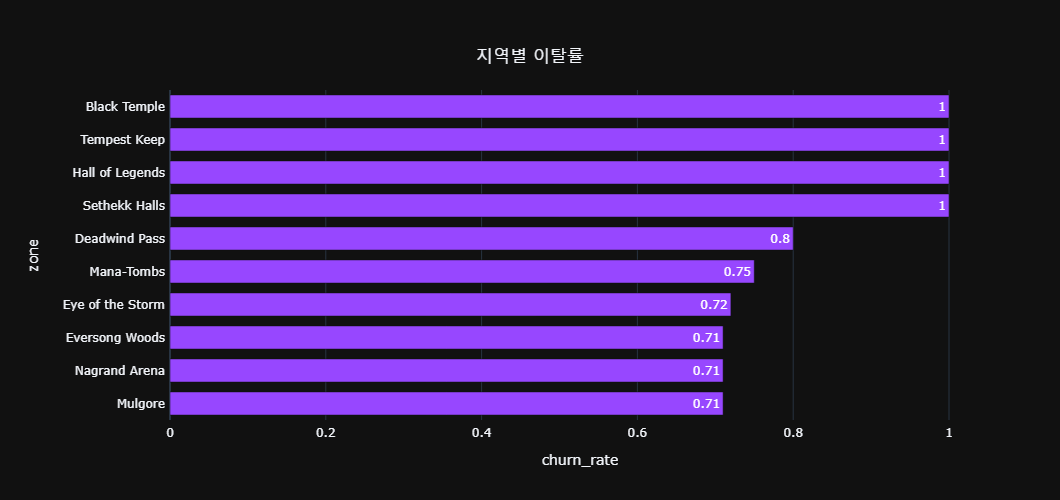

In [263]:
fig = px.bar(churn_zone_top10,  x='churn_rate', y='zone', text='churn_rate', width=800, height=500, template='plotly_dark', color_discrete_sequence=['#9747ff'])
fig.update_traces(textfont_size=12, textangle=0, width=0.7)

fig.update_layout(width=800, height=500,
                  title={
                    'text': "지역별 이탈률",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  template='plotly_dark',
                  margin=dict(
                        l=170,
                        r=70,
                        b=80,
                        t=90,
                        pad=4
                    )
                 )
fig.show()

fig.write_image("img/zone_churn.png")

* 세데크 전당, 오그리마 전설의 전당, 폭풍우 요새, 검은 사원 등이 상위권을 차지함.
   
* 이들 지역은 보상이 별로 없거나 난이도가 너무 높아 인기가 없는 지역으로 유명하며, 이로 인해 폭풍우 요새와 검은 사원 등은 추후 입장퀘스트가 없어짐.
* 단 유입 규모 자체가 적은 지역이라 이탈율이 과대 평가되는 측면이 있음.
* 유저 규모가 1000명 이상인 경우를 대상으로 재분석 실시함.

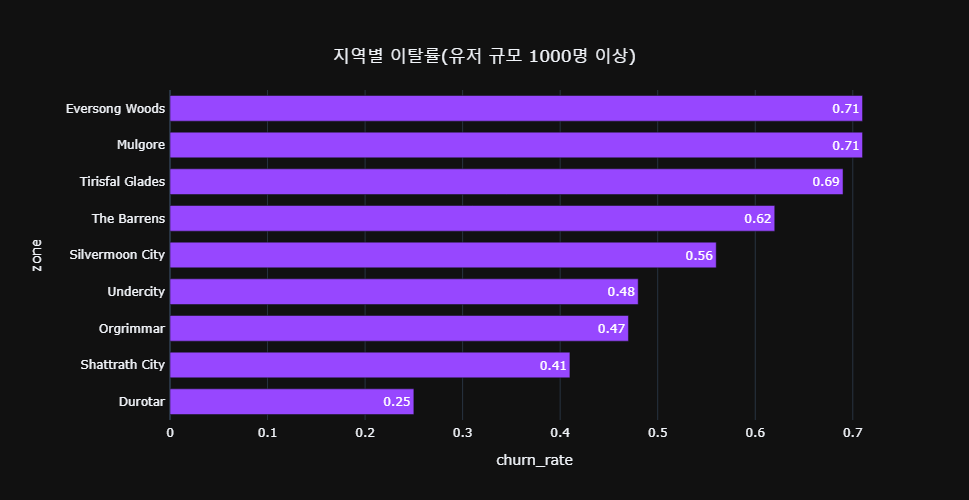

In [264]:
# 1000명 이상 유저 중 이탈률 높은 존들

churn_zone_large = churn_zone[churn_zone.char>1000]
churn_zone_large_top10 = churn_zone_large.sort_values(by='churn_rate', ascending=False)
churn_zone_large_top10 = churn_zone_large_top10[:10].sort_values(by='churn_rate', ascending=True)
churn_zone_large_top10['churn_rate'] = [round(x, 2) for x in churn_zone_large_top10['churn_rate']]

fig = px.bar(churn_zone_large_top10, x='churn_rate', y='zone', text='churn_rate', width=800, height=500, template='plotly_dark', color_discrete_sequence=['#9747ff'])
fig.update_traces(textfont_size=12, textangle=0, width=0.7)

fig.update_layout(width=800, height=500,
                  title={
                    'text': "지역별 이탈률(유저 규모 1000명 이상)",
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  template='plotly_dark',
                  margin=dict(
                        l=170,
                        r=70,
                        b=80,
                        t=90,
                        pad=4
                    )
                 )

fig.show()

fig.write_image("img/zone_churn_large.png")

* 영원노래의 숲, 멀고어, 티리스팔 숲, 불모의 땅, 실버문 등에서 이탈율이 높게 나타남.    
    
* 영원노래의 숲은 동선이 복잡한 것으로 유명함. 멀고어 역시 다른 지역으로 이동하는 데 어려운 동선이 있어 이탈율이 높은 것으로 보임.

## 종족 및 직업별 이탈율
* 종족과 직업 조합 중에 이탈율이 높은 케이스를 분석함.

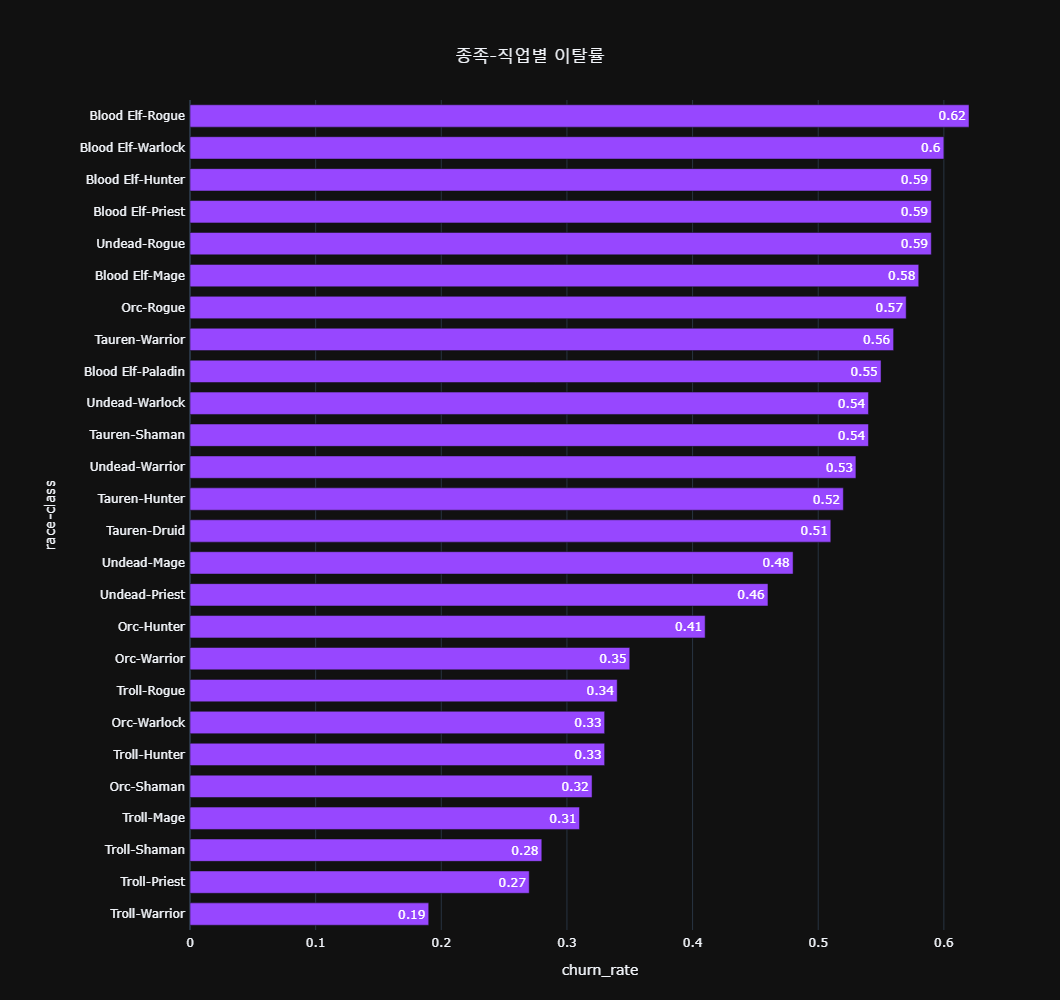

In [271]:
nusers_race_class = last_log.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'total_users'})
cusers_race_class = churn_users.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'churn_users'})

race_n_class = pd.merge(nusers_race_class, cusers_race_class, on=['race', 'charclass'])
race_n_class['churn_rate'] = race_n_class['churn_users'] / race_n_class['total_users']
race_n_class = race_n_class.sort_values(by='churn_rate', ascending=True)

race_n_class['race-class'] = race_n_class['race'] + '-' + race_n_class['charclass']
race_n_class['churn_rate'] = [round(x, 2) for x in race_n_class['churn_rate']]

fig = px.bar(race_n_class, x='churn_rate', y='race-class', text='churn_rate', width=800, height=800, template='plotly_dark', color_discrete_sequence=['#9747ff'])
fig.update_traces(textfont_size=12, textangle=0, width=0.7)


fig.update_layout(width=800, height=1000,
                  title={
                    'text': "종족-직업별 이탈률",
                    'y':0.95,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  template='plotly_dark',
                  margin=dict(
                        l=190,
                        r=50,
                        b=70,
                        t=100,
                        pad=4
                    )
                 )

fig.show()

fig.write_image("img/race_class_churn.png")

* 블러드엘프 종족이 가장 많이 이탈함. 블러드엘프와 도적(rogue), 흑마법사(warlock), 사냥꾼(hunter)의 이탈률이 가장 높음.
* 그밖에 언데드-도적, 오크-도적, 타우렌-전사(warrior) 조합은 이탈율이 높은 편임.
* 이탈율이 가장 종족은 트롤이며, 전사, 사제(priest), 주술사(shaman)와의 조합에서 이탈율이 낮음.
    
* 블러드엘프의 경우 영원노래의 숲에서 게임을 시작하는데 이곳의 퀘스트 동선이 복잡해 이탈율이 높은 것으로 추정됨.